In [1]:
# import keras
# import torch
# import tensorflow as tf

In [2]:
# ! pip install opencv-python

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [3]:
from keras.datasets import mnist

In [4]:
(feat_train, target_train), (feat_test, target_test) = mnist.load_data()

the images have been loaded, now I need to get the size of the datasets

In [5]:
print(feat_train.shape,
feat_test.shape,
target_train.shape,
target_test.shape)

(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)


the image sizes are 28x28 pixels and the training has 60k images, while the test has 10k

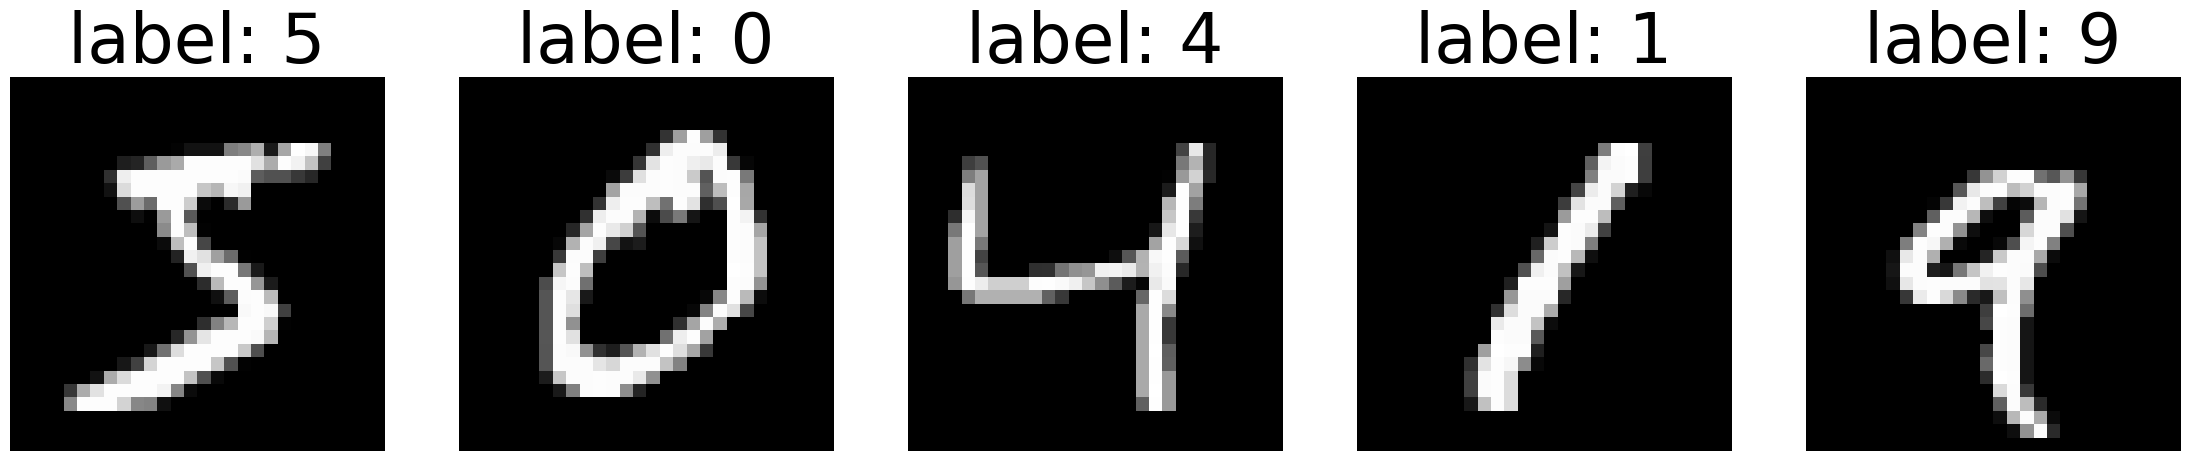

In [6]:
# setting plot size to the size of images
plt.figure(figsize=(28,28))

# loop through 5 images
for image in range(0,5):
    plt.subplot(1,5,image+1) # set the subplot to display images in a line and increment with each image
    plt.imshow(feat_train[image], cmap='gray') # show the image from the training dataset in grayscale
    plt.title('label: ' + str(target_train[image]),size=50) # the label must be set as a string to be input as a title
    plt.axis('off') # turn off the axis as it is not needed
plt.show()

display images in numerical order

In [7]:
narray = []
narray2 = []

for i in range(10):
    # find the element and take the first indice of that element
    ind = np.where(target_train == i) # where returns the index of an element in an array np.where(array,element)
    narray.append(feat_train[ind[0][0]]) # add an element to the array, where you take the first element, and the first appearance = [0][0]
    narray2.append(target_train[ind[0][0]])

    
narray = np.asarray(narray) # the loop returns a list, so change back to an array
narray2 = np.asarray(narray2)

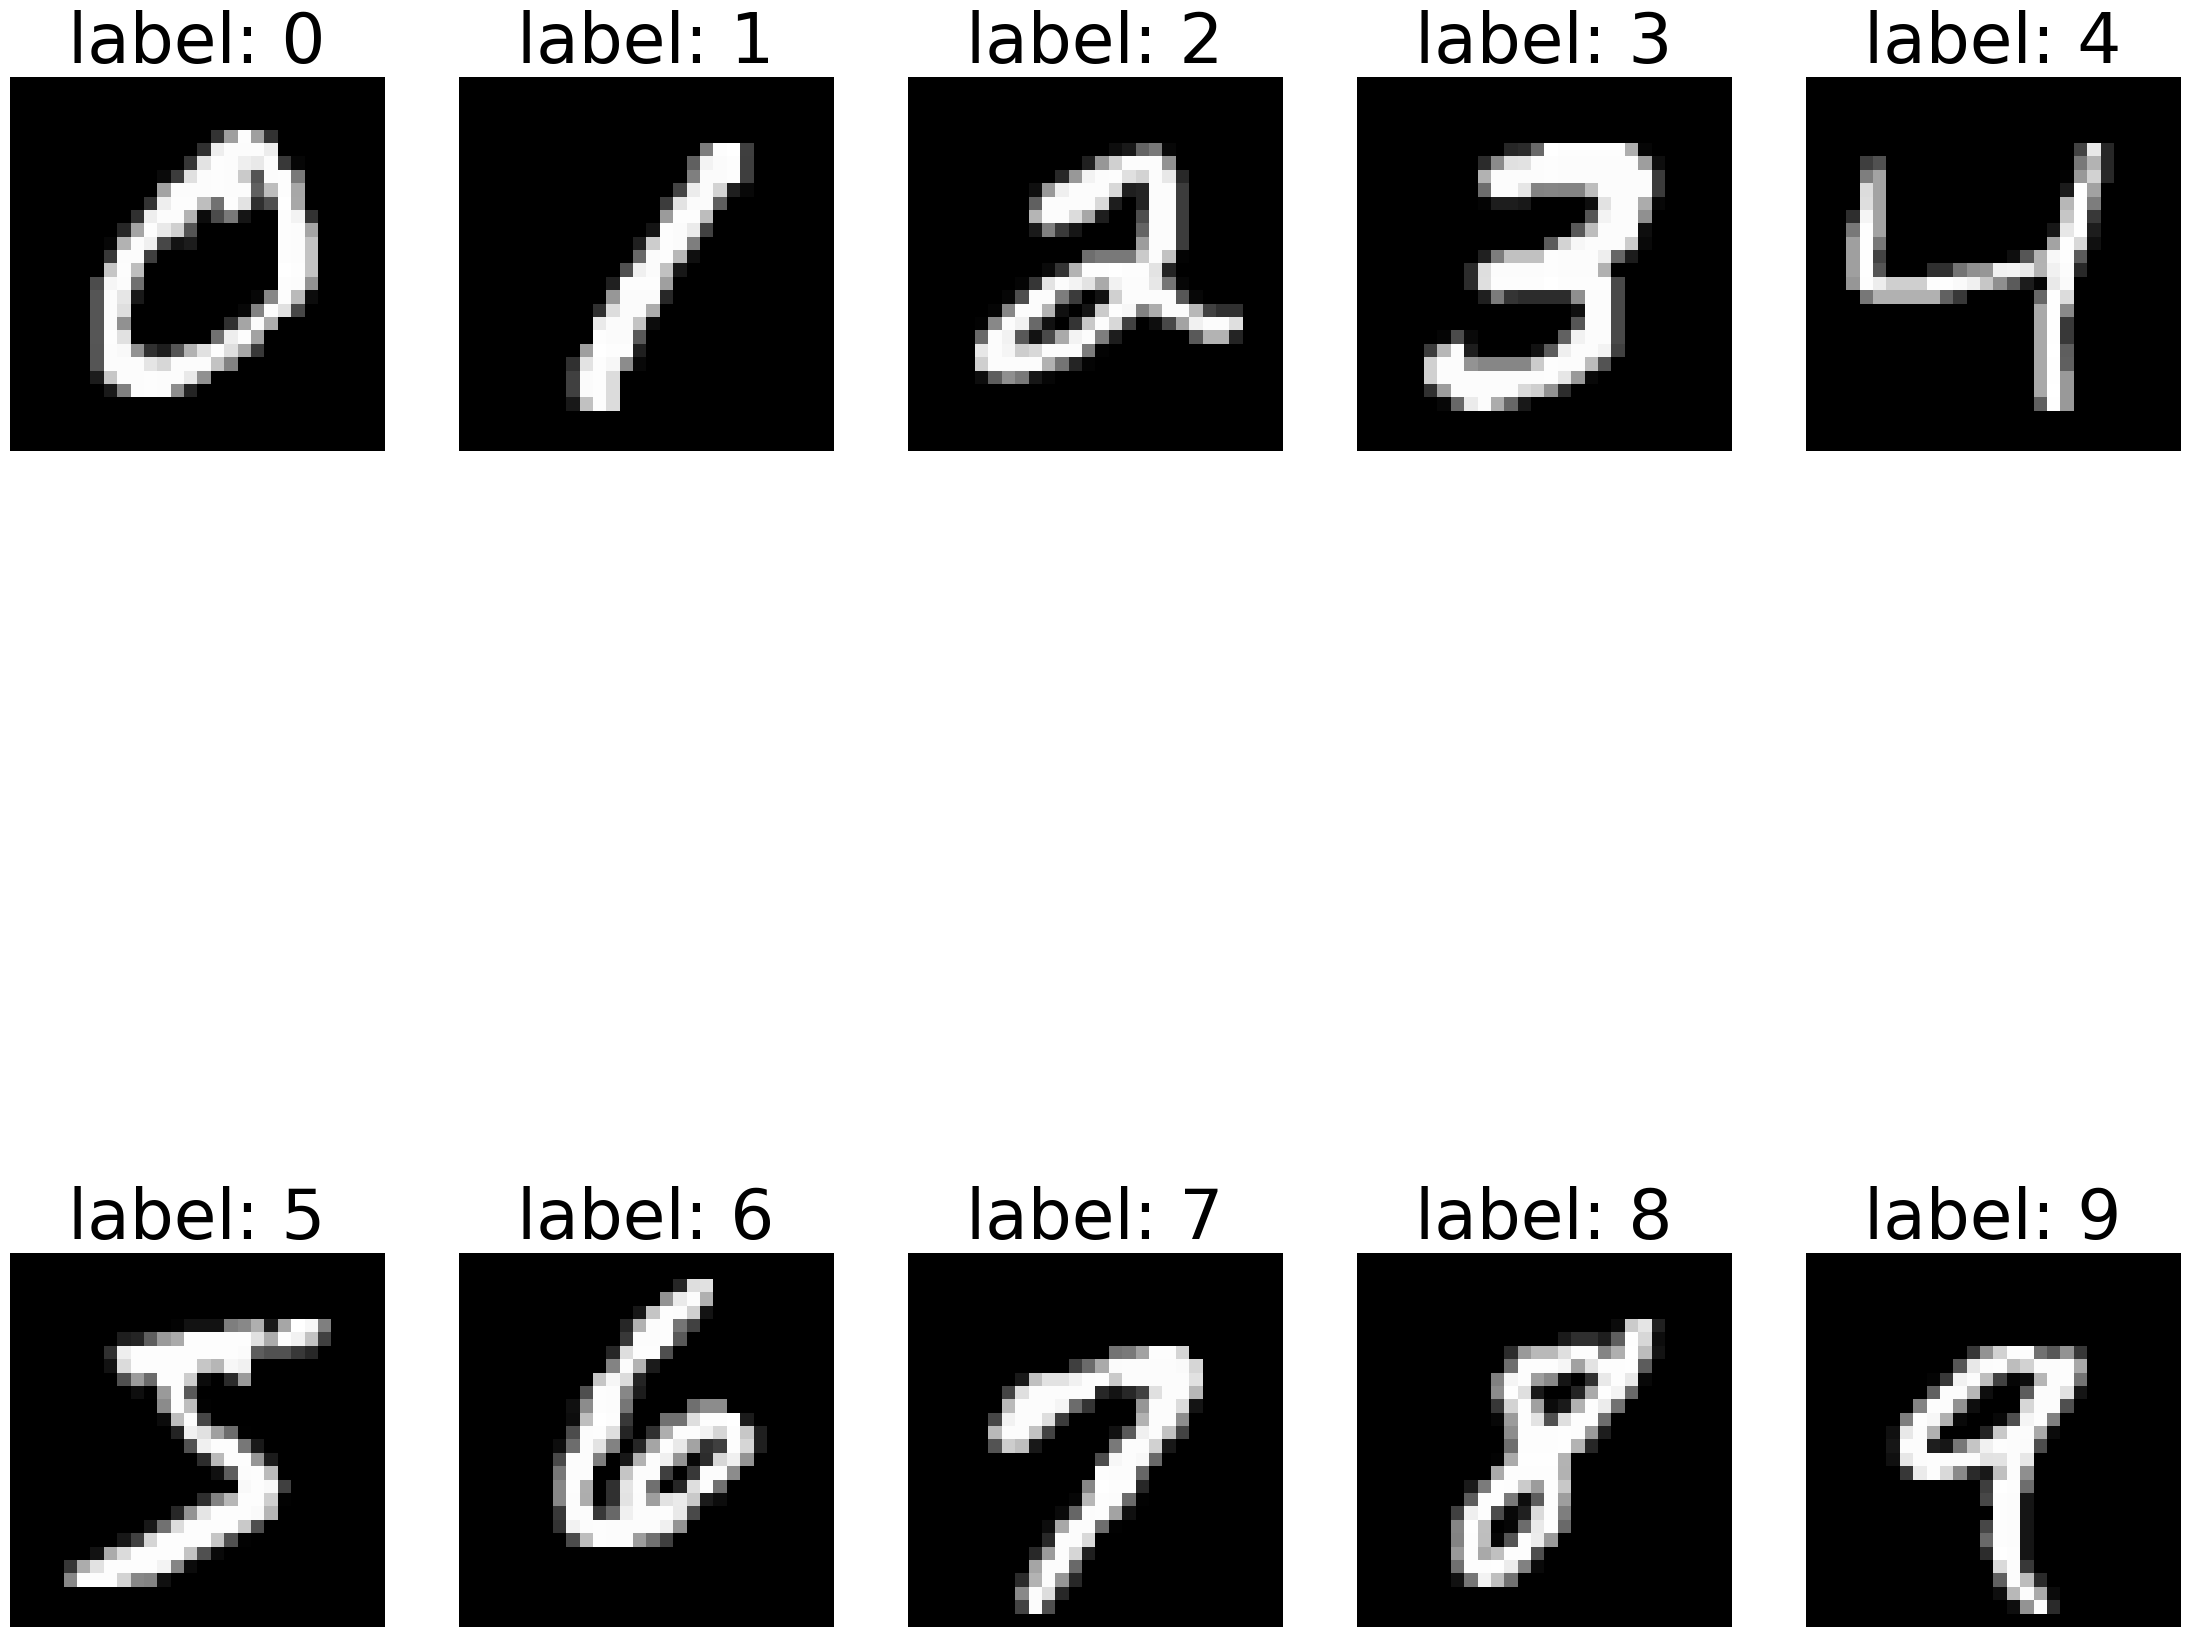

In [8]:
# setting plot size to the size of images
plt.figure(figsize=(28,28))

# loop through 5 images
for image in range(0,10):
    plt.subplot(2,5,image+1) # set the subplot to display images in a line and increment with each image
    plt.imshow(narray[image], cmap='gray') # show the image from the training dataset in grayscale
    plt.title('label: ' + str(narray2[image]),size=50) # the label must be set as a string to be input as a title
    plt.axis('off') # turn off the axis as it is not needed
plt.show()

Make a CNN

In [ ]:
# ! pip3 install torchvision

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

In [27]:
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

100%|█████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 114240956.35it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|████████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<?, ?it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|█████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 103331760.47it/s]

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw




100%|█████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 4556452.71it/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



define convolutional neural network architecture

In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1,32, kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(32,64,kernel_size=3,padding=1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(64*14*14,128)
        self.fc2 = nn.Linear(128,10)
        
    def forward(self,x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(self.dropout1(x),2)
        x = torch.flatten(x,1)
        x = nn.functional.relu(self.fc1(self.dropout2(x)))
        x = self.fc2(x)
        return nn.functional.log_softmax(x,dim=1)

set the device to run on

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

define the data preprocessing steps

In [28]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))
])

create data loaders

In [29]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

initialize model and optimizer

In [30]:
model = Net().to(device)
optimizer = optim.Adam(model.parameters())

compile the model using torch 2.0 optimizer

In [34]:
#model = torch.compile(model)

# the compile is not available in windows, after some research it is not required to run the model so I removed it

define the training loop

In [32]:
model.train()
for batch_idx, (data,target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = nn.functional.nll_loss(output,target)
    loss.backward()
    optimizer.step()

F:\data science\Anaconda\lib\site-packages\torch\nn\functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


define the testing loop

In [39]:
model.eval()
test_loss = 0
correct = 0

allpredictions = []
alltargets = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        
        test_loss += nn.functional.nll_loss(
        output, target, reduction='sum').item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        allpredictions.extend(pred.cpu().numpy())
        alltargets.extend(target.cpu().numpy())
        
test_loss /= len(test_loader.dataset)

F:\data science\Anaconda\lib\site-packages\torch\nn\functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [40]:
test_loss

0.04850040800357237

In [41]:
correct

9851

In [42]:
acc = correct / len(test_dataset)
acc

0.9851

In [38]:
from sklearn.metrics import confusion_matrix

In [44]:
confusion = confusion_matrix(alltargets,allpredictions)

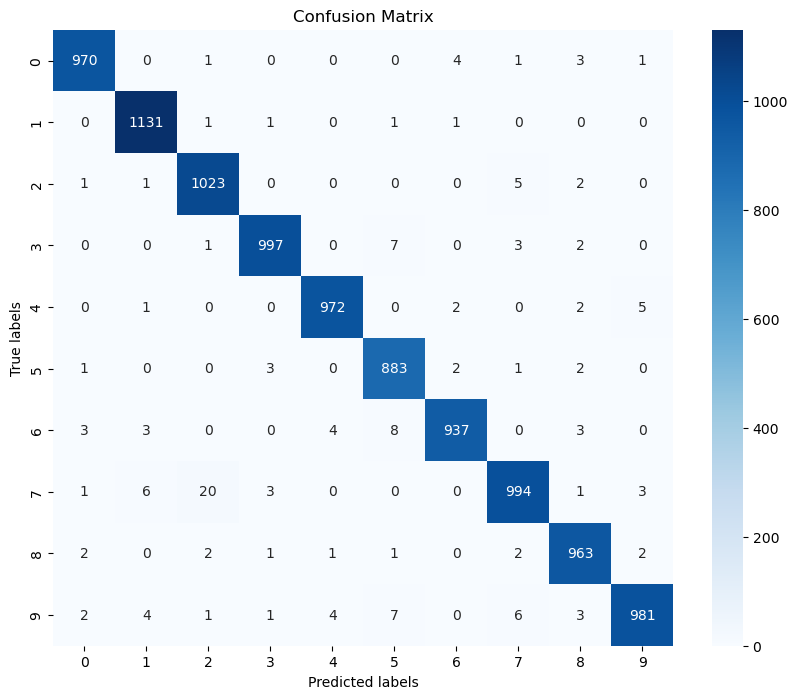

In [45]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

the model did a very good job at detection the label from the image. It looks like the highest error rates came from things like 1 and 7 which is understandable. even then in the grand scheme of things its miniscule error rates.